In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

### Extracting the files/datasets

In [2]:
import zipfile
import os

zip_file_name = '/content/homer_bart.zip'

# Extract the contents
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()

# List the extracted files
extracted_files = os.listdir()
print(extracted_files)

['.config', 'Bart', 'homer_bart.zip', 'Homer', 'sample_data']


In [5]:
# Define paths
base_dir = '/content/'
homer_dir = os.path.join(base_dir, 'Homer')
bart_dir = os.path.join(base_dir, 'Bart')


# Create directories
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


train_homer_dir = os.path.join(train_dir, 'homer')
train_bart_dir = os.path.join(train_dir, 'bart')
test_homer_dir = os.path.join(test_dir, 'homer')
test_bart_dir = os.path.join(test_dir, 'bart')


os.makedirs(train_homer_dir, exist_ok=True)
os.makedirs(train_bart_dir, exist_ok=True)
os.makedirs(test_homer_dir, exist_ok=True)
os.makedirs(test_bart_dir, exist_ok=True)



In [6]:
import shutil
import random


# Function to split data
def split_data(source_dir, train_dir, test_dir, split_size=0.9):
    files = os.listdir(source_dir)
    random.shuffle(files)
    split_idx = int(len(files) * split_size)
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), train_dir)

    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), test_dir)

# Split the data
split_data(homer_dir, train_homer_dir, test_homer_dir)
split_data(bart_dir, train_bart_dir, test_bart_dir)

In [10]:
files = os.listdir(test_homer_dir)
len(files)

11

### Image Augmentation resizing

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# ImageDataGenerator for data augmentation and rescaling
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 242 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


### Build the model

In [17]:
model = Sequential([
    keras.layers.Flatten(input_shape=(64, 64, 3)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 12288)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               6291968   
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6423553 (24.50 MB)
Trainable params: 6423553 (24.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training the model

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30
)


Epoch 1/30
7/7 [==============================] - 3s 206ms/step - loss: 5.0673 - accuracy: 0.5048
Epoch 2/30
7/7 [==============================] - 1s 186ms/step - loss: 3.1893 - accuracy: 0.5048
Epoch 3/30
7/7 [==============================] - 1s 94ms/step - loss: 2.2021 - accuracy: 0.5571
Epoch 4/30
7/7 [==============================] - 1s 99ms/step - loss: 1.1965 - accuracy: 0.5905
Epoch 5/30
7/7 [==============================] - 1s 111ms/step - loss: 0.8172 - accuracy: 0.6238
Epoch 6/30
7/7 [==============================] - 1s 93ms/step - loss: 0.5825 - accuracy: 0.7476
Epoch 7/30
7/7 [==============================] - 1s 88ms/step - loss: 0.6544 - accuracy: 0.7238
Epoch 8/30
7/7 [==============================] - 1s 99ms/step - loss: 0.6076 - accuracy: 0.7476
Epoch 9/30
7/7 [==============================] - 1s 103ms/step - loss: 0.7356 - accuracy: 0.6524
Epoch 10/30
7/7 [==============================] - 1s 108ms/step - loss: 0.4718 - accuracy: 0.7857
Epoch 11/30
7/7 [=======

### Model Evaluation


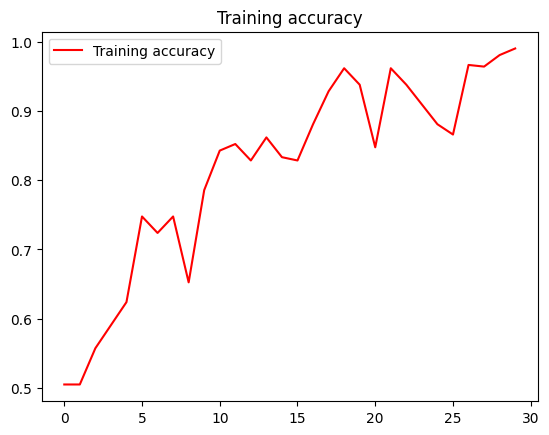

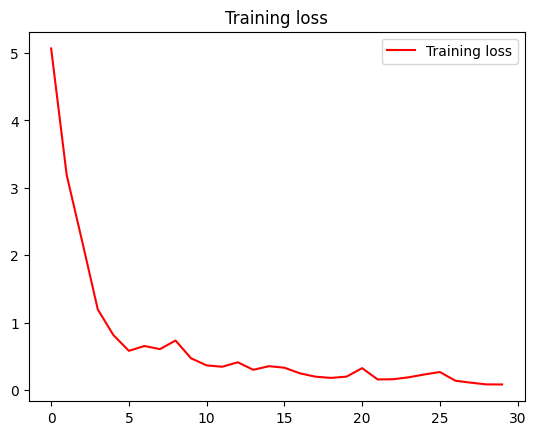

In [19]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()

### Test data - Accuracy

In [21]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1/1 [==============================] - 0s 212ms/step - loss: 0.8569 - accuracy: 0.6667
Test Loss: 0.8568564057350159
Test Accuracy: 0.6666666865348816


### Convert all images to grayscale and split it for training

In [40]:
# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.bmp'):
            img_path = os.path.join(directory, filename)
            image = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            image = img_to_array(image)
            images.append(image)
            labels.append(0 if 'Homer' in directory else 1)  # Assuming homer folder is labeled as 0, dog folder as 1
    return np.array(images), np.array(labels)

# Load cat and dog images
homer_images, homer_labels = load_images(homer_dir)
bart_images, bart_labels = load_images(bart_dir)

# Combine cat and dog images and labels
images = np.concatenate((homer_images, bart_images), axis=0)
labels = np.concatenate((homer_labels, bart_labels), axis=0)

# Split data into train and test sets (with no validation set)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.1, random_state=42)

# Normalize pixel values to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0


In [ ]:
len(train_images),len(train_labels),train_labels,test_labels

### Build the model and train

In [193]:
# model = Sequential([
#     keras.layers.Flatten(input_shape=(64, 64, 1)),
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.Dense(256, activation='relu'),
#     keras.layers.Dense(1, activation='sigmoid')
# ])

def model1():
  inputs = keras.Input(shape=(64,64,1))
  x = keras.layers.Flatten()(inputs)
  x = keras.layers.Dense(512)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dense(256)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dense(128)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

model = model1()

# inputs = keras.Input(shape=(64,64,1))
# x = keras.layers.Dense(512)(inputs)
# x = keras.layers.BatchNormalization()(x)
# x = keras.activations.relu(x)
# x = keras.layers.Dense(256)(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.activations.relu(x)
# output = keras.layers.Dense(1, activation='sigmoid')
# model = keras.Model(inputs=inputs, outputs=output)

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten_29 (Flatten)        (None, 4096)              0         
                                                                 
 dense_98 (Dense)            (None, 512)               2097664   
                                                                 
 dropout_24 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_44 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 tf.nn.relu_43 (TFOpLambda)  (None, 512)               0         
                                                          

In [194]:
# Train the model
model.fit(train_images, train_labels, epochs=60, batch_size=32, verbose=1)


Epoch 1/60
8/8 [==============================] - 2s 31ms/step - loss: 0.7013 - accuracy: 0.5950
Epoch 2/60
8/8 [==============================] - 0s 28ms/step - loss: 0.7431 - accuracy: 0.5579
Epoch 3/60
8/8 [==============================] - 0s 30ms/step - loss: 0.7270 - accuracy: 0.5702
Epoch 4/60
8/8 [==============================] - 0s 30ms/step - loss: 0.6813 - accuracy: 0.6281
Epoch 5/60
8/8 [==============================] - 0s 35ms/step - loss: 0.7138 - accuracy: 0.5702
Epoch 6/60
8/8 [==============================] - 0s 29ms/step - loss: 0.7025 - accuracy: 0.6074
Epoch 7/60
8/8 [==============================] - 0s 29ms/step - loss: 0.6996 - accuracy: 0.5620
Epoch 8/60
8/8 [==============================] - 0s 29ms/step - loss: 0.5857 - accuracy: 0.6529
Epoch 9/60
8/8 [==============================] - 0s 34ms/step - loss: 0.6780 - accuracy: 0.6157
Epoch 10/60
8/8 [==============================] - 0s 29ms/step - loss: 0.6674 - accuracy: 0.6198
Epoch 11/60
8/8 [============

In [195]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f'Test Accuracy: {test_accuracy}')


Test Accuracy: 0.7407407164573669
